# Around DeepSensor in Eighty Lines

This notebook will demonstrate the bare bones of an end-to-end pipeline in DeepSensor. We will
- Load the data
- Preprocess the data
- Construct a task loader
- Construct a model
- Train the model
- Predict on a test task
- TODO: Perform active learning


In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import deepsensor.torch as deepsensor
# import deepsensor.tensorflow as deepsensor
from deepsensor.data.processor import DataProcessor
from deepsensor.data.loader import TaskLoader
from deepsensor.model.convnp import ConvNP

In [3]:
from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.utils import construct_x1x2_ds, construct_circ_time_ds

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import lab as B
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
sns.set_style("white")
from tqdm import tqdm

In [5]:
crs = ccrs.LambertAzimuthalEqualArea(0, -90)
test_date = pd.Timestamp("2014-01-01")

In [6]:
# Run on GPU if available by setting GPU as default device
set_gpu_default_device()

In [7]:
era5_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/gridded/interim/tas_anom/*.nc').sel(time=slice("1990-01-01", None))
era5_raw_ds

<xarray.Dataset>
Dimensions:    (time: 11323, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(365, 280, 280), meta=np.ndarray>

In [8]:
aux_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/auxiliary/interim/*25000m/*.nc')
aux_raw_ds = aux_raw_ds[['surface', 'mask']]
aux_raw_ds

<xarray.Dataset>
Dimensions:  (y: 280, x: 280)
Coordinates:
  * y        (y) float64 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    lat      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    surface  (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    mask     (y, x) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [9]:
data_processor = DataProcessor(
    x1_name='y', x1_map=(0, 3.5e6),
    x2_name='x', x2_map=(0, 3.5e6),
    verbose=True,
)
era5_ds = data_processor(era5_raw_ds, method="mean_std")
aux_ds = data_processor(aux_raw_ds, method="min_max")

Normalisation params for t2m not computed. Computing now... Done. t2m mean=0.314, std=3.883
Normalisation params for surface not computed. Computing now... Done. surface min=0.000, max=4047.722
Normalisation params for mask not computed. Computing now... Done. mask min=0.000, max=1.000


In [10]:
era5_ds

<xarray.Dataset>
Dimensions:    (time: 11323, x1: 280, x2: 280)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2020-12-31
  * x1         (x1) float64 0.9964 0.9893 0.9821 ... -0.9821 -0.9893 -0.9964
  * x2         (x2) float64 -0.9964 -0.9893 -0.9821 ... 0.9821 0.9893 0.9964
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Data variables:
    t2m        (time, x1, x2) float32 -0.07878 -0.06337 ... -0.01156 -0.04221

In [11]:
x1x2_ds = construct_x1x2_ds(aux_ds)
aux_ds['x1_arr'] = x1x2_ds['x1_arr']
aux_ds['x2_arr'] = x1x2_ds['x2_arr']

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = doy_ds["cos_D"]
aux_ds["sin_D"] = doy_ds["sin_D"]

In [12]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_ds], target=era5_ds['t2m'],
                         context_delta_t=0, target_delta_t=0,)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('surface', 'mask', 'x1_arr', 'x2_arr', 'cos_D', 'sin_D'))
Target variable IDs: (('t2m',),)


In [13]:
model_dim = 30
model = ConvNP(data_processor, task_loader, unet_channels=(model_dim,) * 4, likelihood="cnp")
_ = model(task_loader("2000-01-01"))  # build model
print(f"Model receptive field: {model.model.receptive_field:.2f}")
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

dim_yc inferred from TaskLoader: (1, 6)
dim_yt inferred from TaskLoader: 1
points_per_unit inferred from TaskLoader: 167
encoder_scales inferred from TaskLoader: [0.0035714285913854837, 0.0035714285913854837]
Model receptive field: 0.39
Model has 232,055 parameters


In [14]:
# Rather than training, we will load some pre-trained weights
load_weights = True
if load_weights:
    if deepsensor.backend.str == "tf":
        model.model.load_weights("../model.h5")
    elif deepsensor.backend.str == "torch":
        import torch
        model.model.load_state_dict(torch.load("../model.pt"))

## Active learning

Load station data that we will use to generate initial context set locations for our gridded ERA5 data

In [15]:
station_raw_df = pd.read_csv('../../deepsensor_old/data/antarctica/station/interim/XY_station.csv')
station_raw_df = station_raw_df.rename(columns={'date': 'time'})
station_raw_df['time'] = pd.to_datetime(station_raw_df['time'])
station_raw_df = station_raw_df.set_index(['time', 'y', 'x', 'station']).sort_index()[['tas']]

X_c_raw = station_raw_df.loc["2009-02-15"].reset_index()[["y", "x"]].values.T
X_c = data_processor.map_coord_array(X_c_raw)

In [16]:
task = task_loader(test_date, (X_c, "all"))

In [17]:
mask_ds = aux_raw_ds["mask"]

### Sequential greedy algorithm

Sequentially loop over all search points, passing a query observation to the model at that point and computing the change in acquisition function

In [18]:
from deepsensor.active_learning.algorithms import GreedyAlgorithm
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(y=5, x=5, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=4,
)

In [19]:
from deepsensor.active_learning.acquisition_fns import MeanStddev

acquisition_fn = MeanStddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task)



Placement:   0%|                                                                   | 0/4 [00:00<?, ?it/s]

Placement:  25%|██████████████▊                                            | 1/4 [00:19<00:59, 19.92s/it]

Placement:  50%|█████████████████████████████▌                             | 2/4 [00:39<00:39, 19.74s/it]

Placement:  75%|████████████████████████████████████████████▎              | 3/4 [00:59<00:19, 19.71s/it]

Placement: 100%|███████████████████████████████████████████████████████████| 4/4 [01:18<00:00, 19.74s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


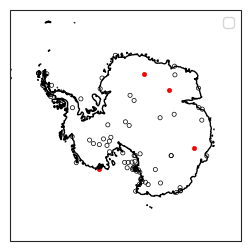

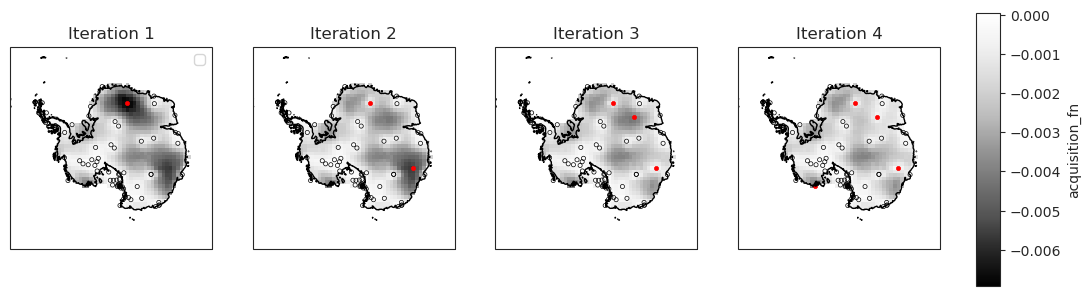

In [20]:
fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

In [21]:
from deepsensor.active_learning.acquisition_fns import MeanVariance

acquisition_fn = MeanVariance(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task)



Placement:   0%|                                                                   | 0/4 [00:00<?, ?it/s]

Placement:  25%|██████████████▊                                            | 1/4 [00:20<01:01, 20.55s/it]

Placement:  50%|█████████████████████████████▌                             | 2/4 [00:41<00:41, 20.61s/it]

Placement:  75%|████████████████████████████████████████████▎              | 3/4 [01:01<00:20, 20.64s/it]

Placement: 100%|███████████████████████████████████████████████████████████| 4/4 [01:22<00:00, 20.64s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


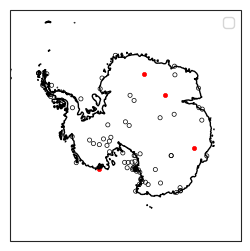

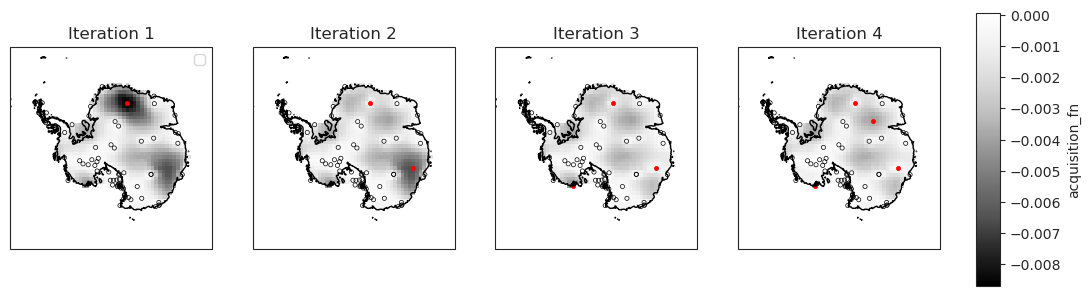

In [22]:
fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

In [23]:
from deepsensor.active_learning.acquisition_fns import pNormStddev

acquisition_fn = pNormStddev(model, p=5)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task)



Placement:   0%|                                                                   | 0/4 [00:00<?, ?it/s]

Placement:  25%|██████████████▊                                            | 1/4 [00:20<01:02, 20.92s/it]

Placement:  50%|█████████████████████████████▌                             | 2/4 [00:41<00:41, 20.86s/it]

Placement:  75%|████████████████████████████████████████████▎              | 3/4 [01:02<00:20, 20.76s/it]

Placement: 100%|███████████████████████████████████████████████████████████| 4/4 [01:23<00:00, 20.77s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


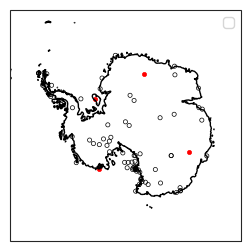

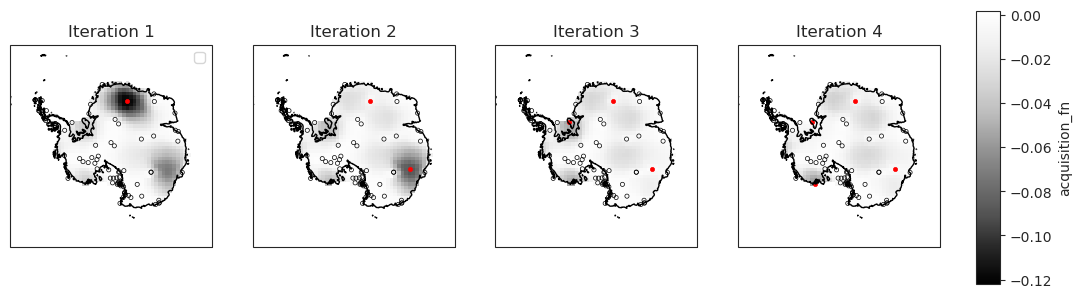

In [24]:
fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### Parallel greedy algorithm

Acquisition functions that can be computed over all search points in parallel are much faster.

In [25]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=50,
)

In [26]:
from deepsensor.active_learning.acquisition_fns import Random

acquisition_fn = Random()
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task)



Placement:   0%|                                                                  | 0/50 [00:00<?, ?it/s]

Placement: 100%|████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 360.55it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


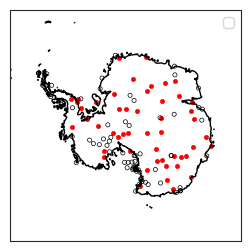

In [27]:
fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))

In [28]:
from deepsensor.active_learning.acquisition_fns import MaxStddev

acquisition_fn = MaxStddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, "max")



Placement:   0%|                                                                  | 0/50 [00:00<?, ?it/s]

Placement:   6%|███▍                                                      | 3/50 [00:00<00:01, 28.27it/s]

Placement:  12%|██████▉                                                   | 6/50 [00:00<00:01, 28.98it/s]

Placement:  18%|██████████▍                                               | 9/50 [00:00<00:01, 29.34it/s]

Placement:  24%|█████████████▋                                           | 12/50 [00:00<00:01, 29.41it/s]

Placement:  32%|██████████████████▏                                      | 16/50 [00:00<00:01, 29.78it/s]

Placement:  38%|█████████████████████▋                                   | 19/50 [00:00<00:01, 29.82it/s]

Placement:  44%|█████████████████████████                                | 22/50 [00:00<00:00, 29.66it/s]

Placement:  50%|████████████████████████████▌                            | 25/50 [00:00<00:00, 29.57it/s]

Placement:  56%|███████████████████

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


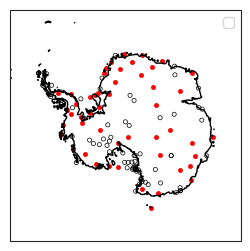

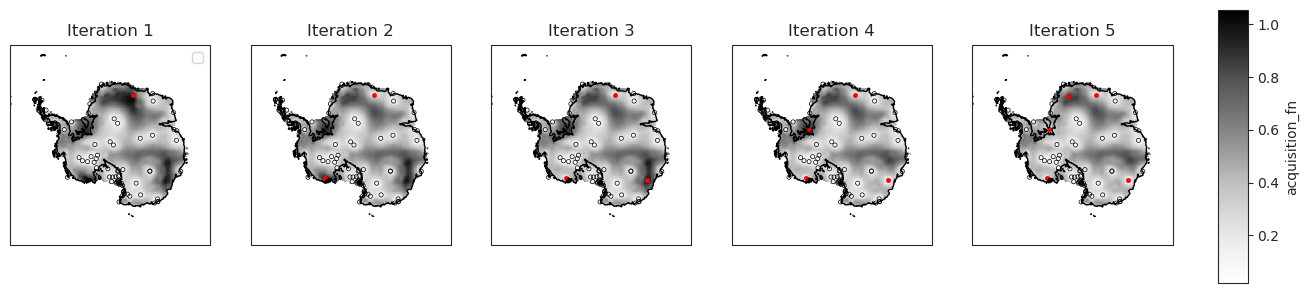

In [29]:
fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds.sel(iteration=slice(0, 4)), X_new_df, data_processor, crs, cmap="Greys")

In [30]:
from deepsensor.active_learning.acquisition_fns import ContextDist

acquisition_fn = ContextDist(0)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, "max")



Placement:   0%|                                                                  | 0/50 [00:00<?, ?it/s]

Placement:   8%|████▋                                                     | 4/50 [00:00<00:01, 35.70it/s]

Placement:  16%|█████████▎                                                | 8/50 [00:00<00:01, 34.73it/s]

Placement:  24%|█████████████▋                                           | 12/50 [00:00<00:01, 31.73it/s]

Placement:  32%|██████████████████▏                                      | 16/50 [00:00<00:01, 28.80it/s]

Placement:  38%|█████████████████████▋                                   | 19/50 [00:00<00:01, 27.55it/s]

Placement:  44%|█████████████████████████                                | 22/50 [00:00<00:01, 26.44it/s]

Placement:  50%|████████████████████████████▌                            | 25/50 [00:00<00:00, 25.57it/s]

Placement:  56%|███████████████████████████████▉                         | 28/50 [00:01<00:00, 24.58it/s]

Placement:  62%|███████████████████

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


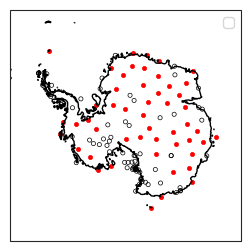

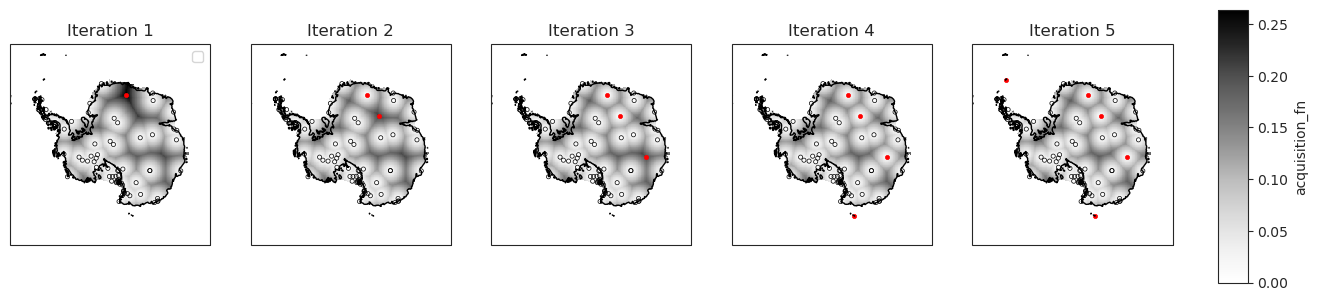

In [31]:
fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds.sel(iteration=slice(0, 4)), X_new_df, data_processor, crs, cmap="Greys")